In [35]:
# Import các module, thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import re
import spacy

from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.initializers import Constant
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

# Mô tả bài toán
Bài toán đặt ra là phân loại câu hỏi trên quora có chứa nội dung toxic hay không (insincere question)
- Input: Câu hỏi dưới dạng văn bản
- Output: Yes/No

# Công việc cần phải thực hiện
1. Tiền xử lý dữ liệu
    - Chuyển về lower case
    - Thay thế các từ viết tắt
    - Loại bỏ các ký tự thừa (kí tự đặc biệt, khoảng trắng thừa, ...)
    - Chuyển từ thành số
    - Đọc vecto embeddings
2. Tạo và huấn luyện mô hình
    - Sử dụng mạng nơ-ron kết hợp với vecto embeddings cho trước
3. Sử dụng mô hình để dự đoán

# Overview dữ liệu

In [11]:
# đọc file dữ liệu để train và test
TRAIN_FILE = '/kaggle/input/quora-insincere-questions-classification/train.csv'
TEST_FILE = '/kaggle/input/quora-insincere-questions-classification/test.csv'
df = pd.read_csv(TRAIN_FILE)
test_set = pd.read_csv(TEST_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


**Kích thước train.csv:** </br>
* Số dòng: 1.31 millions </br>
* Số cột: 3 </br>

**Data field**
+ qid: mã số của câu hỏi (question identifier)
+ quesntion_text: nội dung của câu hỏi cần phân loại (text)
+ target: nhãn của câu hỏi, câu chứa nội dung toxic có nhãn là 1, ngược lại là 0

Dựa vào biểu đồ bên dưới, ta nhận thấy số lượng câu hỏi toxic và câu không toxic khá chênh lệch </br>
Vì vậy tập dữ liệu bị mất cân bằng => Sử dụng F1 score để đánh giá cho tập dữ liệu này

Num of sincere question: 1225312
Num of insincere question: 80810
Ratio = 1516.29 %


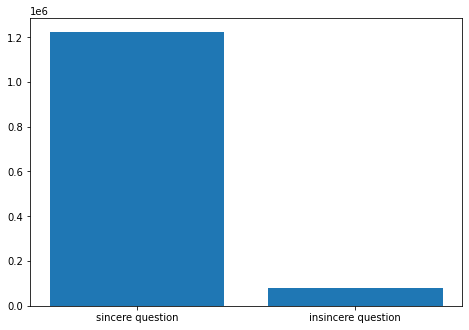

In [12]:
num_insincere = len(df[df['target'] == 1])
num_sincere = len(df[df['target'] == 0])
print("Num of sincere question:", num_sincere)
print("Num of insincere question:", num_insincere)
print("Ratio = {ratio:.2f} %".format(ratio = num_sincere / num_insincere  * 100 ))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['sincere question', 'insincere question'], df.target.value_counts())
plt.show()

# Tiền xử lý dữ liệu

1. **Chia dữ liệu thành 2 phần:**
    - 80% dữ liệu làm tập để train
    - 20% dữ liệu dùng để validate

In [13]:
train, validate = train_test_split(df, test_size = 0.2)

In [14]:
print("Train: num of sincere:", len(train[train.target == 0]))
print("Train: num of insincere:", len(train[train.target == 1]))

print("Validate: num of sincere:", len(validate[validate.target == 0]))
print("Validate: num of insincere:", len(validate[validate.target == 1]))

Train: num of sincere: 980387
Train: num of insincere: 64510
Validate: num of sincere: 244925
Validate: num of insincere: 16300


Reset lại index của các dataframe (bị suffle sau khi chia thành 2 tập train và validate)

In [15]:
train_set = train.reset_index(drop=True)
validate_set = validate.reset_index(drop=True)
display(train_set)

,qid,question_text,target
0,b802175c74aaf0293c39,What does it mean when Mach 2 is used to descr...,0
1,c095478bd6f91a746f64,Why money is important and why it is difficult...,0
2,866b51ce37cbebb80aec,What Mercedes-Benz letter indexes for trucks s...,0
3,9ccaf01c42647d7eea20,Hillary Clinton had a campaign war chest that ...,1
4,34b9177ffb568474df64,Are single people who claim to be happy with t...,0
...,...,...,...
1044892,7f7fe980a04258dcc354,How can I download songs from wesing?,0
1044893,cbcbc7dc980fcacb7a0d,Did lakshmi Rai compromise for julie 2?,0
1044894,fedeb983533241173140,Should I go to grad film school after undergrad?,0
1044895,ca3dd82a72e50fc04283,What would be the roadmap for a Java developer...,0


In [16]:
# raw_train_text = train_set.question_text.to_numpy()
# train_label = train_set.target.to_numpy()

# raw_validate_text = validate_set.question_text.to_numpy()
# validate_label = validate_set.target.to_numpy()

# raw_test_text = test_set.question_text.to_numpy()

**contraction_fix: Sửa các từ viết tắt**

Chuyển các từ viết tắt thành dạng viết đầy đủ của nó

**preprocess_text: chuẩn hóa văn bản:**
- chuyển thành chữ thường
- Sửa các từ viết tắt
- Loại bỏ các ký tự không phải là chữ
- Loại bỏ các khoảng trăng thừa

In [17]:
contractions={"I'm":'I am',"I'm'a":'I am about to',"I'm'o":'I am going to',"I've":'I have',"I'll":'I will',"I'll've":'I will have',"I'd":'I would',"I'd've":'I would have','Whatcha':'What are you',"amn't":'am not',"ain't":'are not',"aren't":'are not',"'cause":'because',"can't":'can not',"can't've":'can not have',"could've":'could have',"couldn't":'could not',"couldn't've":'could not have',"daren't":'dare not',"daresn't":'dare not',"dasn't":'dare not',"didn't":'did not','didn’t':'did not',"don't":'do not','don’t':'do not',"doesn't":'does not',"e'er":'ever',"everyone's":'everyone is','finna':'fixing to','gimme':'give me',"gon't":'go not','gonna':'going to','gotta':'got to',"hadn't":'had not',"hadn't've":'had not have',"hasn't":'has not',"haven't":'have not',"he've":'he have',"he's":'he is',"he'll":'he will',"he'll've":'he will have',"he'd":'he would',"he'd've":'he would have',"here's":'here is',"how're":'how are',"how'd":'how did',"how'd'y":'how do you',"how's":'how is',"how'll":'how will',"isn't":'is not',"it's":'it is',"'tis":'it is',"'twas":'it was',"it'll":'it will',"it'll've":'it will have',"it'd":'it would',"it'd've":'it would have','kinda':'kind of',"let's":'let us','luv':'love',"ma'am":'madam',"may've":'may have',"mayn't":'may not',"might've":'might have',"mightn't":'might not',"mightn't've":'might not have',"must've":'must have',"mustn't":'must not',"mustn't've":'must not have',"needn't":'need not',"needn't've":'need not have',"ne'er":'never',"o'":'of',"o'clock":'of the clock',"ol'":'old',"oughtn't":'ought not',"oughtn't've":'ought not have',"o'er":'over',"shan't":'shall not',"sha'n't":'shall not',"shalln't":'shall not',"shan't've":'shall not have',"she's":'she is',"she'll":'she will',"she'd":'she would',"she'd've":'she would have',"should've":'should have',"shouldn't":'should not',"shouldn't've":'should not have',"so've":'so have',"so's":'so is',"somebody's":'somebody is',"someone's":'someone is',"something's":'something is','sux':'sucks',"that're":'that are',"that's":'that is',"that'll":'that will',"that'd":'that would',"that'd've":'that would have','em':'them',"there're":'there are',"there's":'there is',"there'll":'there will',"there'd":'there would',"there'd've":'there would have',"these're":'these are',"they're":'they are',"they've":'they have',"they'll":'they will',"they'll've":'they will have',"they'd":'they would',"they'd've":'they would have',"this's":'this is',"those're":'those are',"to've":'to have','wanna':'want to',"wasn't":'was not',"we're":'we are',"we've":'we have',"we'll":'we will',"we'll've":'we will have',"we'd":'we would',"we'd've":'we would have',"weren't":'were not',"what're":'what are',"what'd":'what did',"what've":'what have',"what's":'what is',"what'll":'what will',"what'll've":'what will have',"when've":'when have',"when's":'when is',"where're":'where are',"where'd":'where did',"where've":'where have',"where's":'where is',"which's":'which is',"who're":'who are',"who've":'who have',"who's":'who is',"who'll":'who will',"who'll've":'who will have',"who'd":'who would',"who'd've":'who would have',"why're":'why are',"why'd":'why did',"why've":'why have',"why's":'why is',"will've":'will have',"won't":'will not',"won't've":'will not have',"would've":'would have',"wouldn't":'would not',"wouldn't've":'would not have',"y'all":'you all',"y'all're":'you all are',"y'all've":'you all have',"y'all'd":'you all would',"y'all'd've":'you all would have',"you're":'you are',"you've":'you have',"you'll've":'you shall have',"you'll":'you will',"you'd":'you would',"you'd've":'you would have','jan.':'january','feb.':'february','mar.':'march','apr.':'april','jun.':'june','jul.':'july','aug.':'august','sep.':'september','oct.':'october','nov.':'november','dec.':'december','I’m':'I am','I’m’a':'I am about to','I’m’o':'I am going to','I’ve':'I have','I’ll':'I will','I’ll’ve':'I will have','I’d':'I would','I’d’ve':'I would have','amn’t':'am not','ain’t':'are not','aren’t':'are not','’cause':'because','can’t':'can not','can’t’ve':'can not have','could’ve':'could have','couldn’t':'could not','couldn’t’ve':'could not have','daren’t':'dare not','daresn’t':'dare not','dasn’t':'dare not','doesn’t':'does not','e’er':'ever','everyone’s':'everyone is','gon’t':'go not','hadn’t':'had not','hadn’t’ve':'had not have','hasn’t':'has not','haven’t':'have not','he’ve':'he have','he’s':'he is','he’ll':'he will','he’ll’ve':'he will have','he’d':'he would','he’d’ve':'he would have','here’s':'here is','how’re':'how are','how’d':'how did','how’d’y':'how do you','how’s':'how is','how’ll':'how will','isn’t':'is not','it’s':'it is','’tis':'it is','’twas':'it was','it’ll':'it will','it’ll’ve':'it will have','it’d':'it would','it’d’ve':'it would have','let’s':'let us','ma’am':'madam','may’ve':'may have','mayn’t':'may not','might’ve':'might have','mightn’t':'might not','mightn’t’ve':'might not have','must’ve':'must have','mustn’t':'must not','mustn’t’ve':'must not have','needn’t':'need not','needn’t’ve':'need not have','ne’er':'never','o’':'of','o’clock':'of the clock','ol’':'old','oughtn’t':'ought not','oughtn’t’ve':'ought not have','o’er':'over','shan’t':'shall not','sha’n’t':'shall not','shalln’t':'shall not','shan’t’ve':'shall not have','she’s':'she is','she’ll':'she will','she’d':'she would','she’d’ve':'she would have','should’ve':'should have','shouldn’t':'should not','shouldn’t’ve':'should not have','so’ve':'so have','so’s':'so is','somebody’s':'somebody is','someone’s':'someone is','something’s':'something is','that’re':'that are','that’s':'that is','that’ll':'that will','that’d':'that would','that’d’ve':'that would have','there’re':'there are','there’s':'there is','there’ll':'there will','there’d':'there would','there’d’ve':'there would have','these’re':'these are','they’re':'they are','they’ve':'they have','they’ll':'they will','they’ll’ve':'they will have','they’d':'they would','they’d’ve':'they would have','this’s':'this is','those’re':'those are','to’ve':'to have','wasn’t':'was not','we’re':'we are','we’ve':'we have','we’ll':'we will','we’ll’ve':'we will have','we’d':'we would','we’d’ve':'we would have','weren’t':'were not','what’re':'what are','what’d':'what did','what’ve':'what have','what’s':'what is','what’ll':'what will','what’ll’ve':'what will have','when’ve':'when have','when’s':'when is','where’re':'where are','where’d':'where did','where’ve':'where have','where’s':'where is','which’s':'which is','who’re':'who are','who’ve':'who have','who’s':'who is','who’ll':'who will','who’ll’ve':'who will have','who’d':'who would','who’d’ve':'who would have','why’re':'why are','why’d':'why did','why’ve':'why have','why’s':'why is','will’ve':'will have','won’t':'will not','won’t’ve':'will not have','would’ve':'would have','wouldn’t':'would not','wouldn’t’ve':'would not have','y’all':'you all','y’all’re':'you all are','y’all’ve':'you all have','y’all’d':'you all would','y’all’d’ve':'you all would have','you’re':'you are','you’ve':'you have','you’ll’ve':'you shall have','you’ll':'you will','you’d':'you would','you’d’ve':'you would have'}
def contraction_fix(word):
  try:
      a=contractions[word]
  except KeyError:
      a=word
  return a

def preprocess_text(doc):
  arr = []
  for text in tqdm(doc):
    text=text.lower() # Chuyển thành chữ thường
    text=" ".join([contraction_fix(w) for w in text.split()]) # sửa từ viết tắt
    text=re.sub(r'[^a-zA-Z]'," ",text) # Loại bỏ ký tự không phỉa là chữ
    text = re.sub(r' {2,}', ' ', text) # Loại bỏ các khoảng trắng thừa
    arr.append(text.strip())
  return arr

In [20]:
train_text = preprocess_text(train_set.question_text)
train_label = train_set.target

validate_text = preprocess_text(validate_set.question_text)
validate_label = validate_set.target

test_text = preprocess_text(test_set.question_text)


  0%|          | 0/1044897 [00:00<?, ?it/s]

  0%|          | 0/261225 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

# Visualize text sau khi xử lý

In [21]:
visualize_preprocessing = pd.DataFrame()
visualize_preprocessing['question_text'] = train_set.question_text
visualize_preprocessing['clean_text'] = train_text
with pd.option_context('display.max_colwidth', 100):
    print("Sincere question")
    display(visualize_preprocessing[train_label == 0].head())
    print("Insincere question")
    display(visualize_preprocessing[train_label == 1].head())

Sincere question


,question_text,clean_text
0,What does it mean when Mach 2 is used to describe speed?,what does it mean when mach is used to describe speed
1,Why money is important and why it is difficult to earn it?,why money is important and why it is difficult to earn it
2,"What Mercedes-Benz letter indexes for trucks stand for, for example LNR, SLP, LS etc?",what mercedes benz letter indexes for trucks stand for for example lnr slp ls etc
4,Are single people who claim to be happy with their status lying to themselves?,are single people who claim to be happy with their status lying to themselves
6,"What advice would you give to someone who is moving to Suzuka, Mie, Japan?",what advice would you give to someone who is moving to suzuka mie japan


Insincere question


,question_text,clean_text
3,Hillary Clinton had a campaign war chest that was 32 times larger than Donald Trump. Why did she...,hillary clinton had a campaign war chest that was times larger than donald trump why did she onl...
5,"Do slave descendants around the world personalize, internalize & identify with their ancestors' ...",do slave descendants around the world personalize internalize identify with their ancestors slav...
23,How will the transition of white Americans from the majority to the minority play out?,how will the transition of white americans from the majority to the minority play out
39,Are the British and the Americans responsible for all the hatred in the world?,are the british and the americans responsible for all the hatred in the world
54,Will Americans be efficient in IT sector as Indians are?,will americans be efficient in it sector as indians are


# Chuyển từ thành số

In [22]:
# sử dụng nlp spaCy để token word => tạo lemma_dict (để tra cứu từ gốc của một từ khi so sánh)
# ví dụ "goes", "went", "gone" cùng trả về từ "go"
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','tagger'])

In [23]:
# tần suẩt xuất hiện
vocab_freq = {}
# index của từ
word2index = {}
# từ gốc
lemma_dict = {}
def sentences2sequences(sentences):
    docs = nlp.pipe(sentences, n_threads = 2)
    word_sequences = []
    for doc in tqdm(docs, total=len(sentences)):
        word_seq = []
        for token in doc:
            if token.text not in word2index: # kiểm tra từ có trong từ điển hay không
                word2index[token.text] = len(vocab_freq) # gắn index cho từ
                lemma_dict[token.text] = token.lemma_ # lấy từ gốc của từ
                vocab_freq[token.text] = 1
            else:
                vocab_freq[token.text] += 1 # tăng tần suất thêm 1
            word_seq.append(word2index[token.text])
        word_sequences.append(word_seq)
    return word_sequences

In [24]:
train_sequences = sentences2sequences(train_text)
validate_sequences = sentences2sequences(validate_text)
test_sequences = sentences2sequences(test_text)

vocab_size = len(word2index)
print('Found %s unique tokens.' % len(word2index))

  0%|          | 0/1044897 [00:00<?, ?it/s]

  0%|          | 0/261225 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

Found 204014 unique tokens.


**Thực hiện padding và truncating sequences**

Do các câu hỏi có độ dài không bằng nhau, để dễ huấn luyện thì ta chuẩn hóa tất cả các input về cùng một độ dài cố định bằng ký thuật padding và truncating 

- padding: nếu chuỗi bị ngắn thì thực hiện padding bằng các thêm 0 vào đăng sau chuỗi.
    
- truncating: nếu chuỗi bị dài thì ta làm ngắn bằng cách bỏ đi phần dư ra ở cuối chuỗi.


In [25]:
MAX_SENTENCE_LENGTH = 100 # Độ dài tối đa của chuỗi
PADDING_TYPE = 'post' # kiểu padding, post = cuối chuỗi
TRUNCATE_TYPE = 'post'# kiểu truncating, post = cuối chuỗi

padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
padded_validate_sequences = pad_sequences(validate_sequences, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_SENTENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)

print(padded_train_sequences)
print(padded_train_sequences.shape)

[[  0   1   2 ...   0   0   0]
 [ 11  12   6 ...   0   0   0]
 [  0  17  18 ...   0   0   0]
 ...
 [247 109 678 ...   0   0   0]
 [  0  90  55 ...   0   0   0]
 [139 108 109 ...   0   0   0]]
(1044897, 100)


# Đọc vecto embeddings
- Với mỗi từ trong từ điển, lấy ra vecto embedding tương ứng
- Nếu không tim thấy vecto embedding tương ứng với từ thì gán no từ đó có weight [-1,-1,-,1,...-1] (len = 300)

In [26]:
EMBEDDING_DIM = 300 # chọn số chiều của vecto embedding là 300

ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')
def load_embedding(word2vec):
    oov_count = 0 # Số lượng từ không tìm thấy vecto embeddings
    vocab_count = 0 # Số lượng từ có vecto embeddings
    
    embedding_weights = np.zeros((vocab_size+1, EMBEDDING_DIM)) # khởi tạo trọng số weight = 0
    unknown_vector = np.zeros((EMBEDDING_DIM,), dtype=np.float32) - 1
    unknown_words = {}

    # Tìm kiếm từng từ trong embeddings, nếu không thấy thì lần lượt thực hiện các kỹ thuật biến đổi từ để tìm ra từ gần nghĩa.
    # => hi vọng embeddings cho trước phủ được càng nhiều từ càng tốt.
    for key, i in tqdm(word2index.items()):
        word = key
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
        
        # PorterStemmer ("python","pythoner","pythoning","pythoned" => "python")
        word = ps.stem(key)        
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
        
        # LancasterStemmer
        word = lc.stem(key)        
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
            
        # SnowballStemmer (connection, connections, connective, connected, and connecting => connect)
        word = sb.stem(key)        
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
            
        # Lemmanization
        word = lemma_dict[key]     
        if word in word2vec: 
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue

        try:
            unknown_words[key] += 1
        except KeyError:
            unknown_words[key] = 1
            
        embedding_weights[i] = unknown_vector
        oov_count += vocab_freq[key]

    print('Top 10 Null word embeddings: ')
    print(list(unknown_words.items())[:10])
    print('\n')
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_weights, axis=1) == -1 * EMBEDDING_DIM))
    print('Null word embeddings percentage: %.2f%%' % (100 * oov_count / vocab_count))
    
    return embedding_weights

**Đọc file embeddings, chuyển thành dict để tra cứu vecto embeddings**

In [27]:
# tách từ và vecto tương ứng với nó
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
# lấy số dòng của file embeddings
def get_lines_count(file_name): 
    return sum(1 for _ in open(file_name, encoding="utf8", errors='ignore'))
# chuyển file embeddigns thành dict
def load_vec(file_name): 
    return dict(
        get_coefs(*o.split(" ")) 
            for o in tqdm(open(
                file_name, encoding="utf8", errors='ignore'), 
                total=get_lines_count(file_name)
            ) if len(o) > 100
    )

In [28]:
# giải nén file zip

GLOVE_FILE = 'glove.840B.300d/glove.840B.300d.txt'
# PARAGRAM_FILE = 'paragram_300_sl999/paragram_300_sl999.txt'
# WIKI_NEWS_FILE = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {GLOVE_FILE} -d .
# !unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {PARAGRAM_FILE} -d .
# !unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {WIKI_NEWS_FILE} -d .

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip


In [29]:
print('loading glove_vec')
glove_vec = load_vec(GLOVE_FILE)
glove_weights = load_embedding(glove_vec)
del glove_vec
gc.collect()

loading glove_vec


  0%|          | 0/2196017 [00:00<?, ?it/s]

  0%|          | 0/204014 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('truecaller', 1), ('chebyshev', 1), ('prakhar', 1), ('brathwaite', 1), ('mangalyaan', 1), ('apporoach', 1), ('mppsc', 1), ('mahadeshwwa', 1), ('cogenitor', 1), ('yiannopoulos', 1)]


Null word embeddings: 62014
Null word embeddings percentage: 0.50%


0

In [30]:
# tạo strategy sử dụng TPU để train model
strategy = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


In [31]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Tạo model 
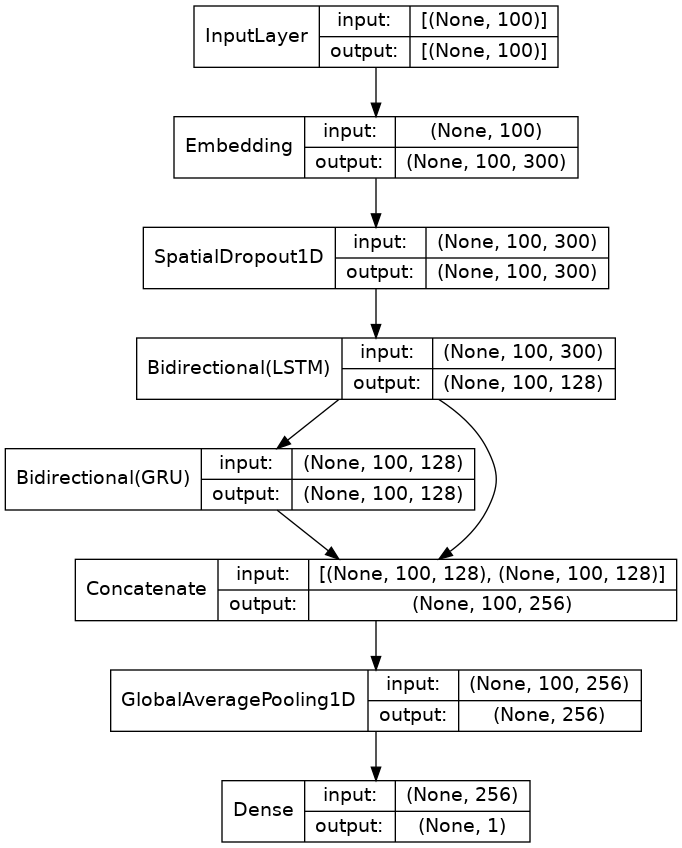

In [37]:
def create_model(units=64, learning_rate = 0.01):
    output_bias = Constant(np.log([num_insincere/num_sincere]))
    
    x_input = Input(shape=(MAX_SENTENCE_LENGTH))
    glove_embedding = Embedding(len(glove_weights), EMBEDDING_DIM, input_length=MAX_SENTENCE_LENGTH, weights=[glove_weights], trainable=False)(x_input)
    x = SpatialDropout1D(0.2)(glove_embedding)
    
    lstm = Bidirectional(LSTM(units, return_sequences=True))(x)
    gru = Bidirectional(GRU(units, return_sequences=True))(lstm)
    
    x = Concatenate()([lstm, gru])
    x = GlobalAveragePooling1D()(x)
    
    x_output = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    
    model = Model(inputs=x_input, outputs=x_output)
    opt = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer= opt, metrics=[f1_m])
    return model

In [33]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
n_epochs = 10
batch_size=1024
class_weight = {
    0: 1,
    1: 3,
}
callbacks = [
    ModelCheckpoint("best_classification_model/best.hdf5", monitor = "val_f1_m", save_best_only = True, mode = "max", verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5,min_lr=0.001 ,patience=1)
]

In [38]:
with strategy.scope():
    model = create_model(units = 64)
    model.summary()
    plot_model(model, 'model.png', show_shapes=True, show_layer_names=False)
    
    history = model.fit(padded_train_sequences, train_label, batch_size=batch_size, epochs=n_epochs, validation_data=(padded_validate_sequences, validate_label), class_weight=class_weight, callbacks = callbacks)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     61204500    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 128)     186880      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

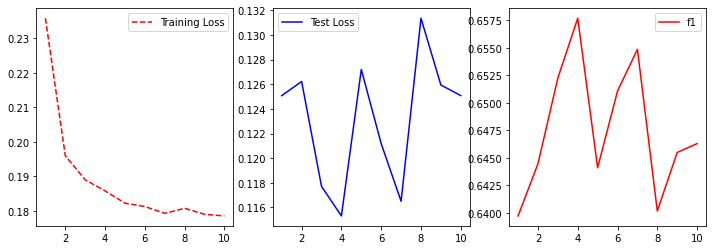

In [39]:
def plot_graph_train(history):
  training_loss = history['loss']
  test_loss = history['val_loss']
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)
  # Visualize loss history
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1,figsize=(12,4))

  ax1.plot(epoch_count, training_loss, 'r--')
  ax1.legend(['Training Loss'])

  ax2.plot(epoch_count, test_loss, 'b-')
  ax2.legend(['Test Loss'])
  
  val_f1 = history['val_f1_m']
  ax3.plot(epoch_count, val_f1, 'r-' )
  ax3.legend(['f1'])

  plt.show();
plot_graph_train(history.history)

In [40]:
# load best model
best_model = load_model('./best_classification_model/best.hdf5', compile=False)
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

128/128 [==============================] - 78s 603ms/step
Max f1_score = 0.67, at threshold = 0.52


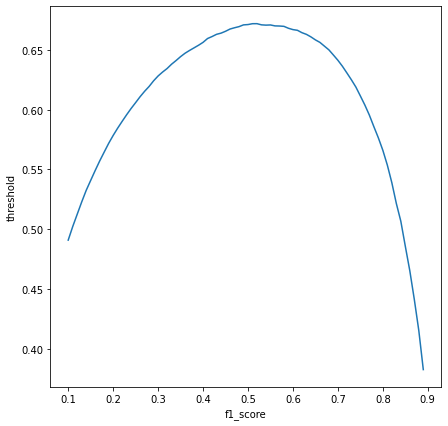

In [41]:
threshold = 0
y_pre=best_model.predict(padded_validate_sequences, verbose=1, batch_size=2048)
max_f1 = 0
f1s = []
threshes = np.arange(0.1,0.9,0.01)
for thresh in threshes:
    f1 = metrics.f1_score(validate_label,(y_pre>thresh).astype(int))
    if f1 > max_f1:
        max_f1 = f1
        threshold=thresh
    f1s.append(f1)

print("Max f1_score = {f1:.2f}, at threshold = {thresh:.2f}".format(f1=max_f1, thresh=threshold))
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
ax.plot(threshes, f1s)
ax.set_xlabel('f1_score')
ax.set_ylabel('threshold')
plt.show()


In [42]:
print("predict with threshold = {threshold:.2f}".format(threshold=threshold))
y_test_pre=model.predict(padded_test_sequences, verbose=1, batch_size=2048)
y_test_pre=(y_test_pre>threshold).astype(int)

## Creating the submission File
submit=pd.DataFrame()
submit["qid"]=test_set.qid
submit["prediction"]=y_test_pre
submit.to_csv("submission.csv",index=False)

predict with threshold = 0.52
184/184 [==============================] - 6s 26ms/step
